In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math

In [2]:
folder_path =  '/users/mmotuz/GBO_REU/GOALS/'

df1 = pd.read_csv(folder_path + 'goals_v6.csv', skiprows = None)


162


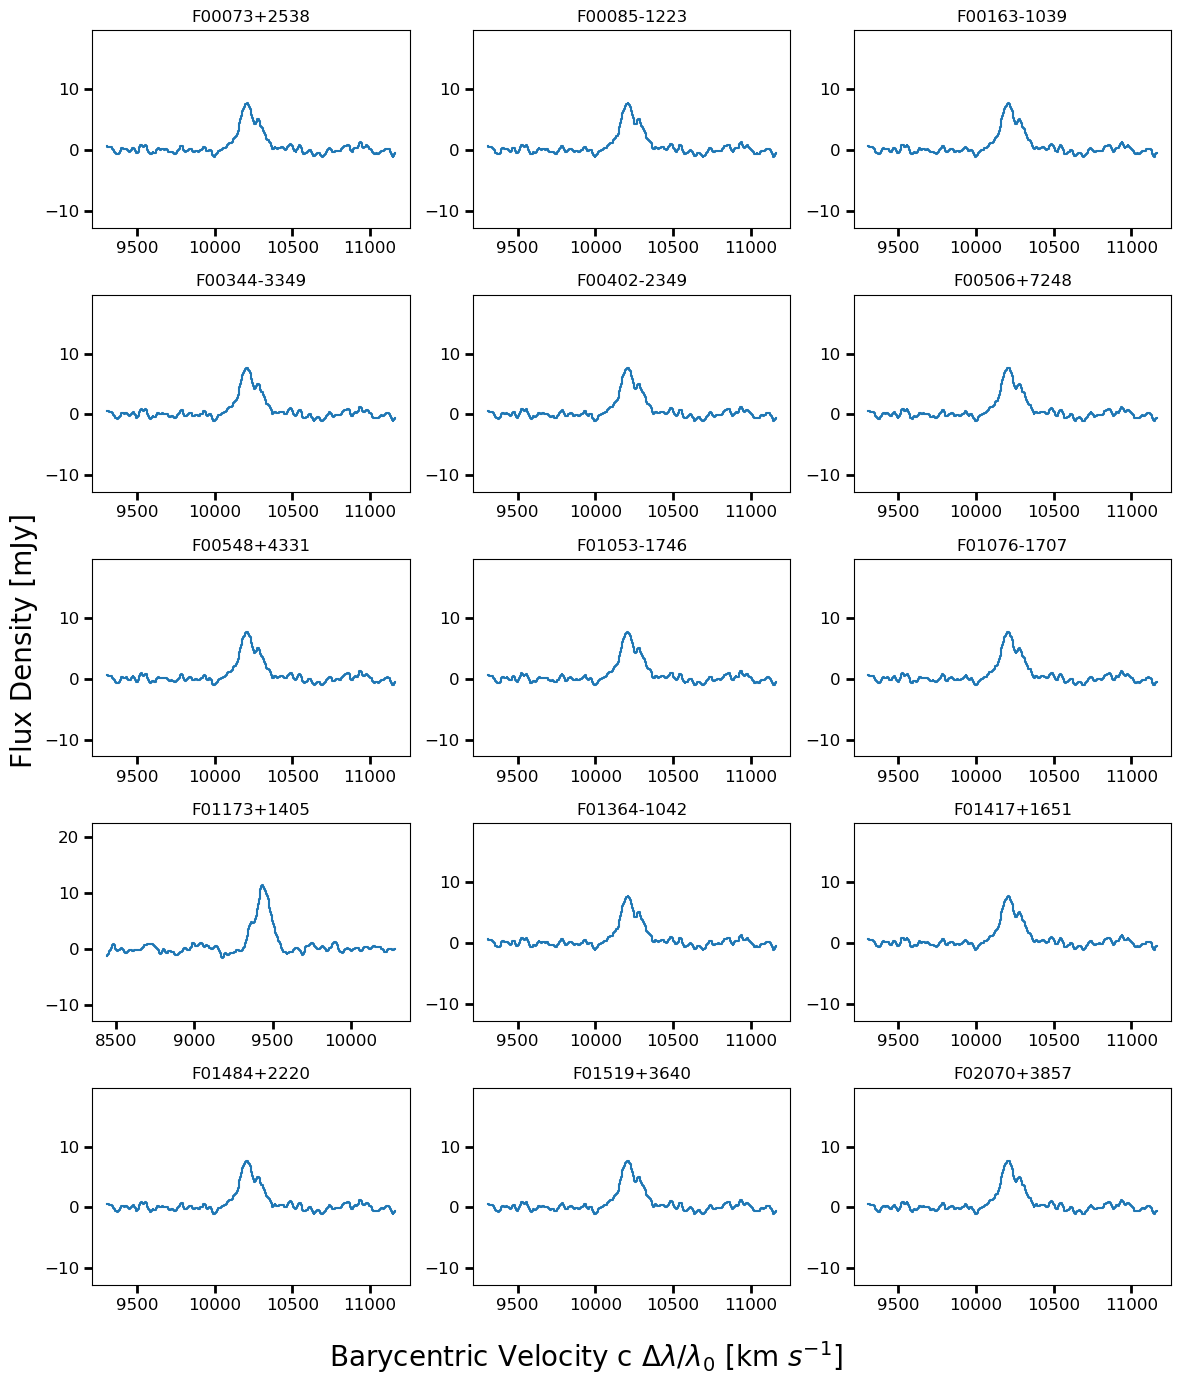

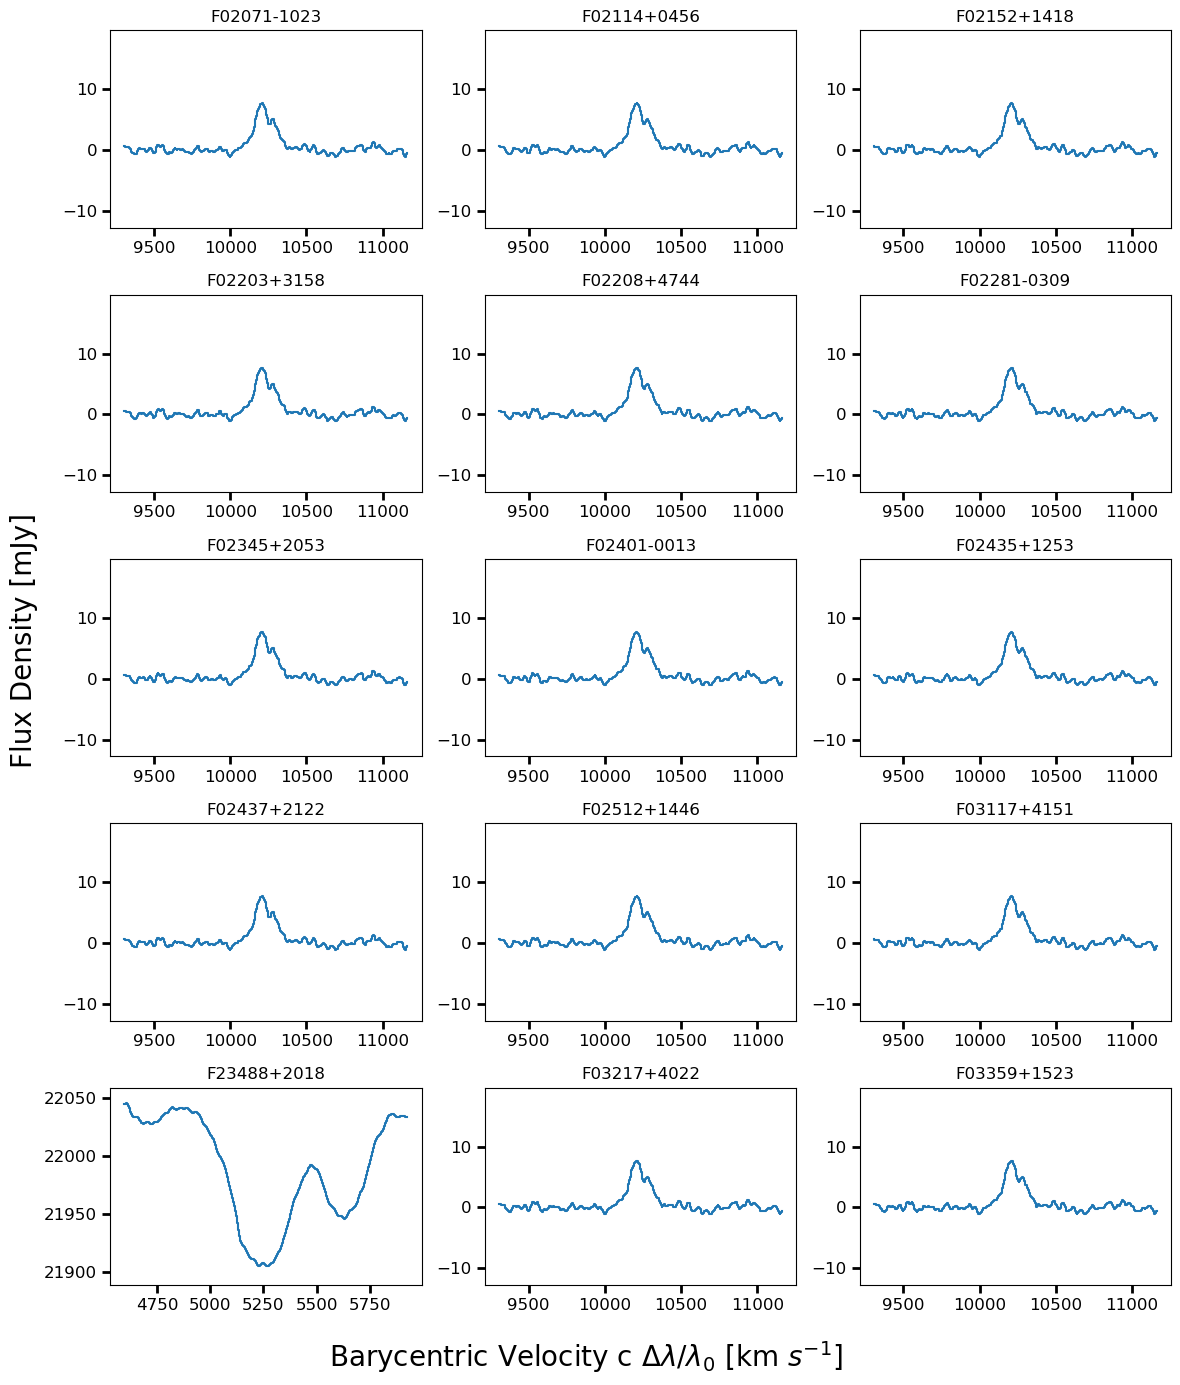

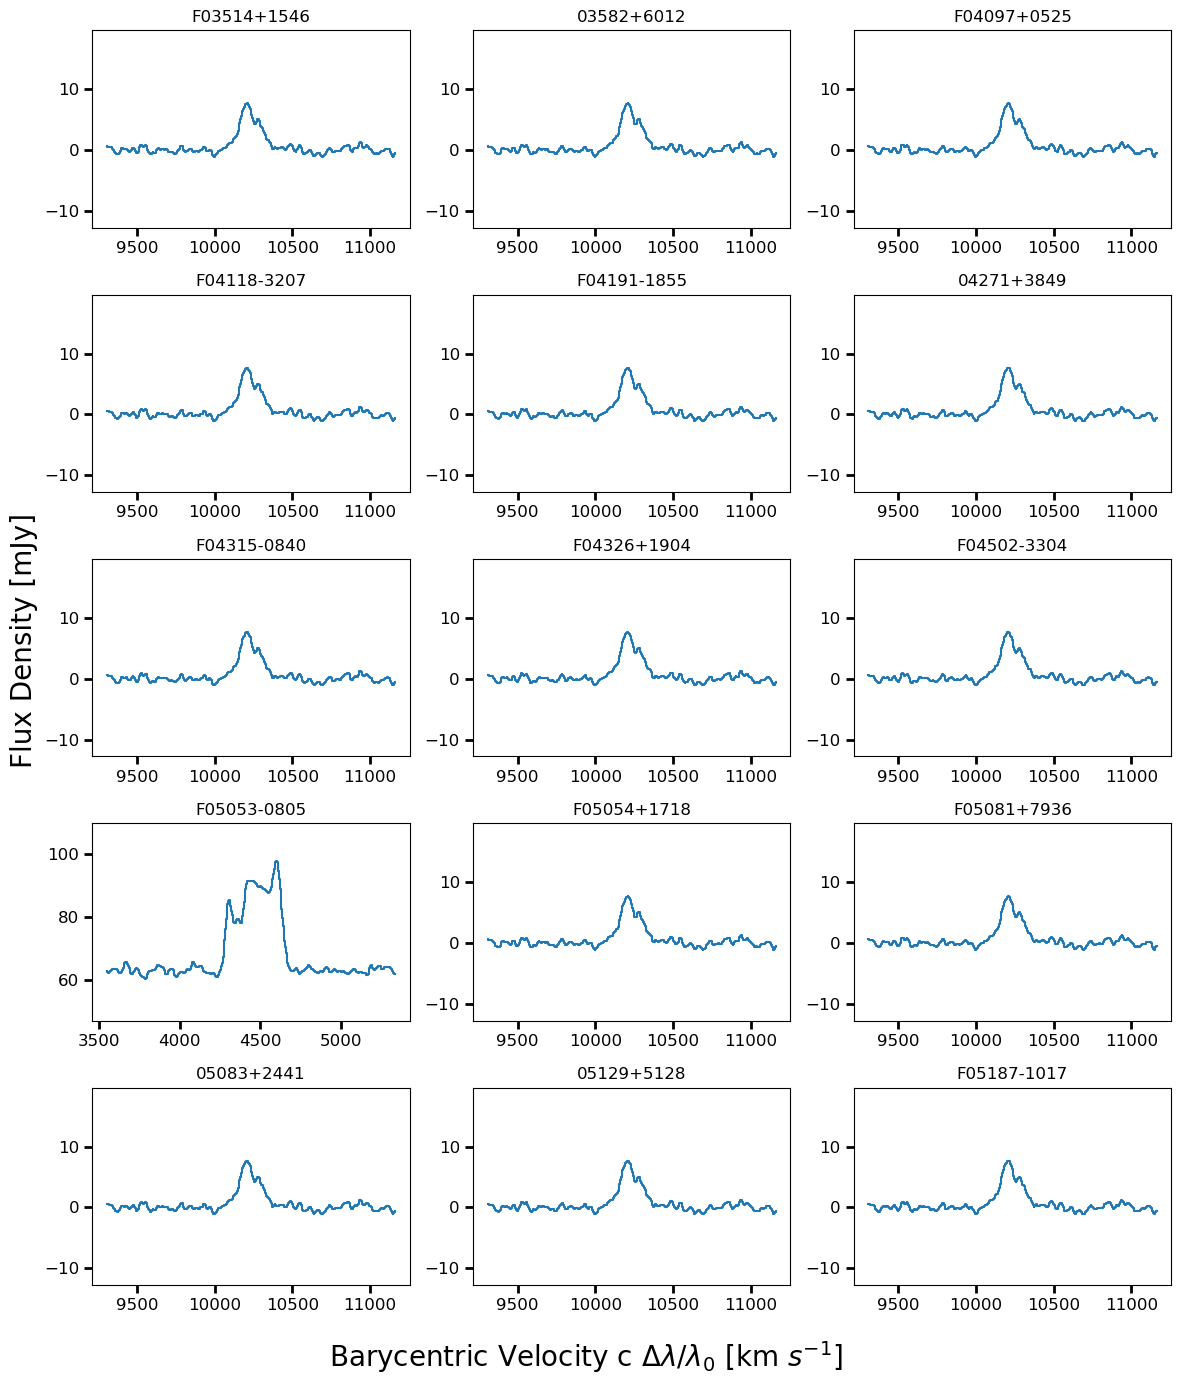

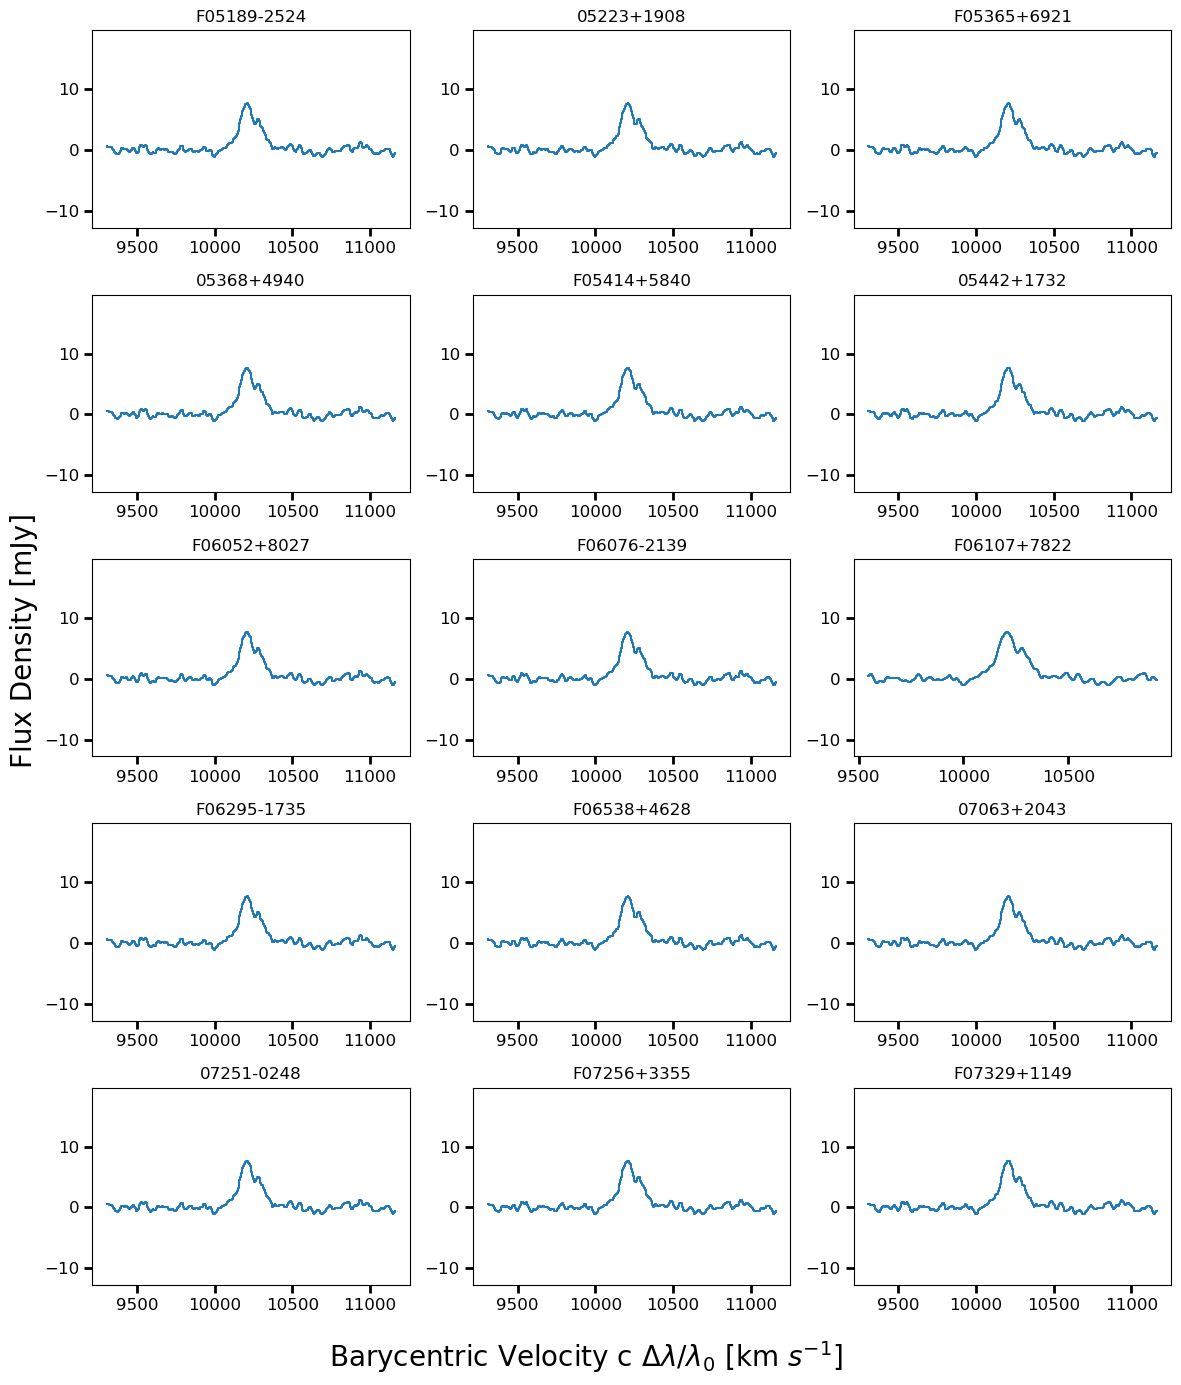

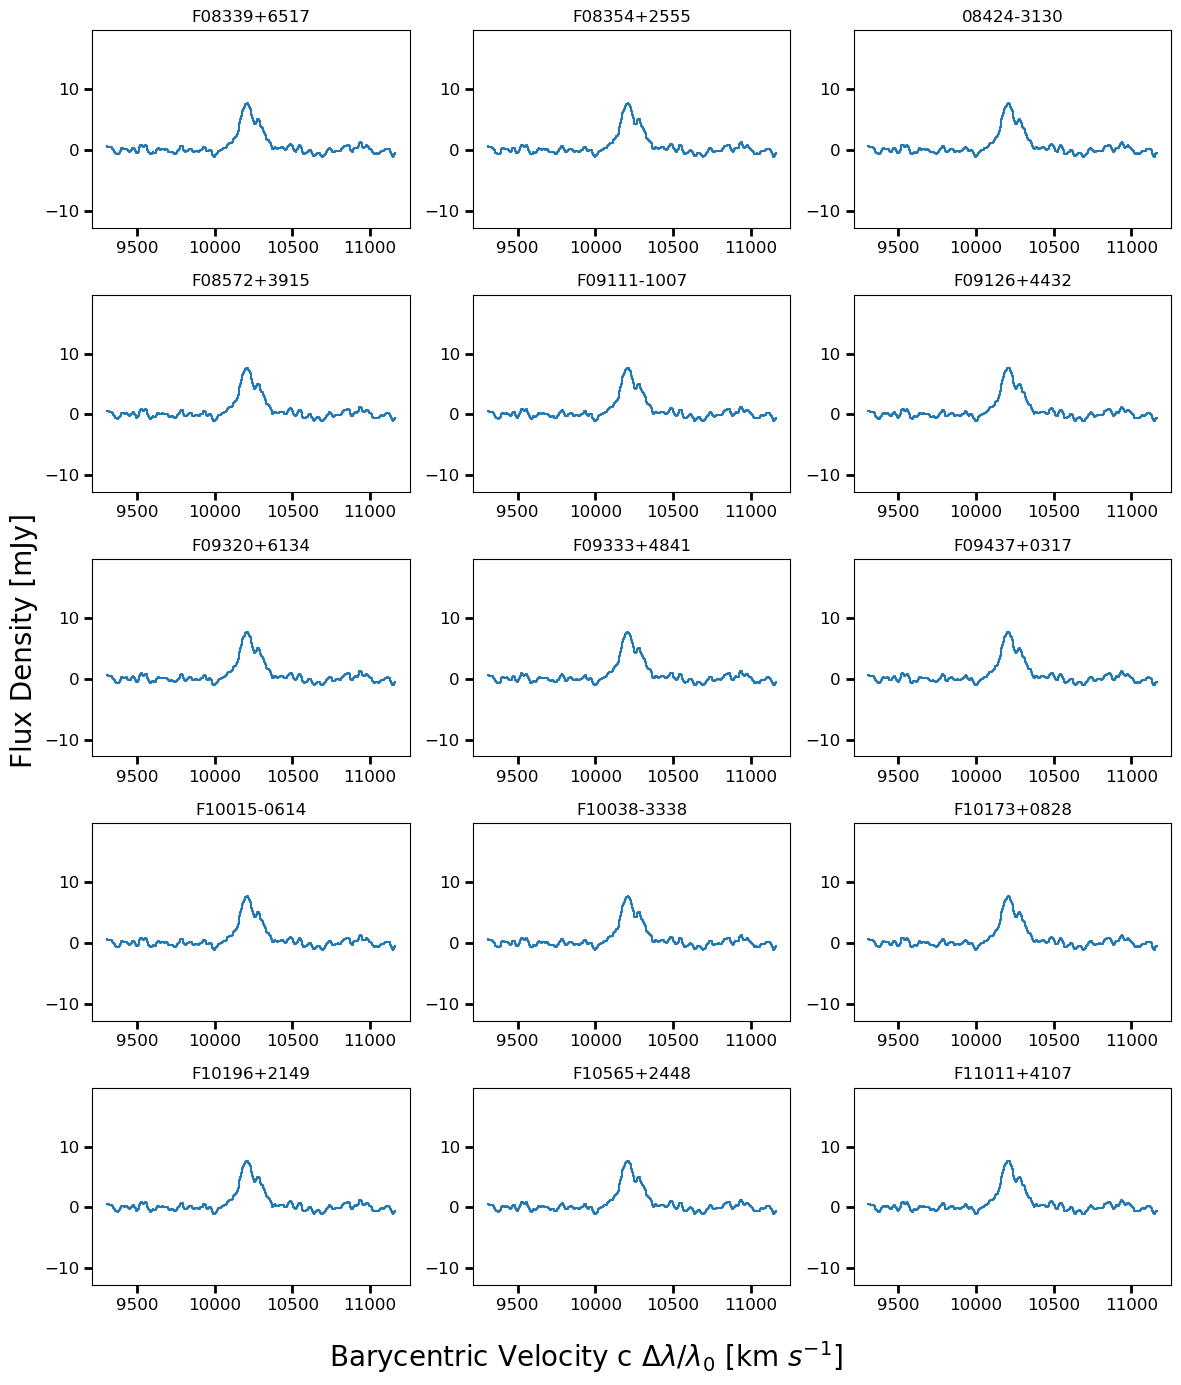

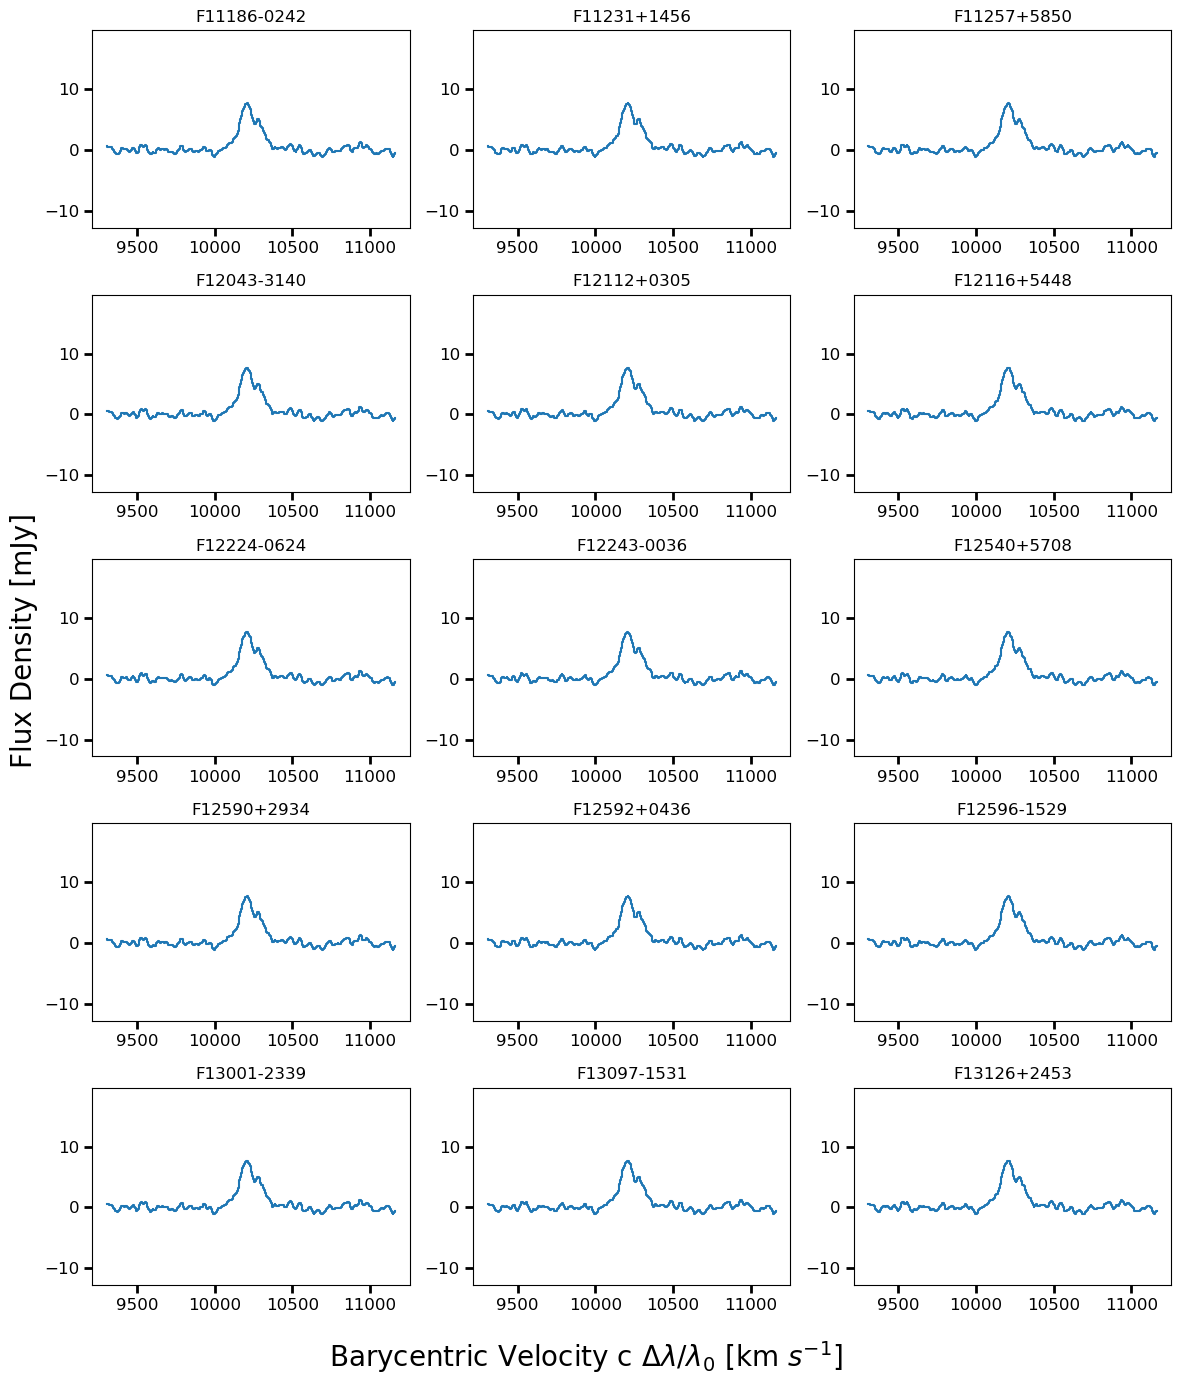

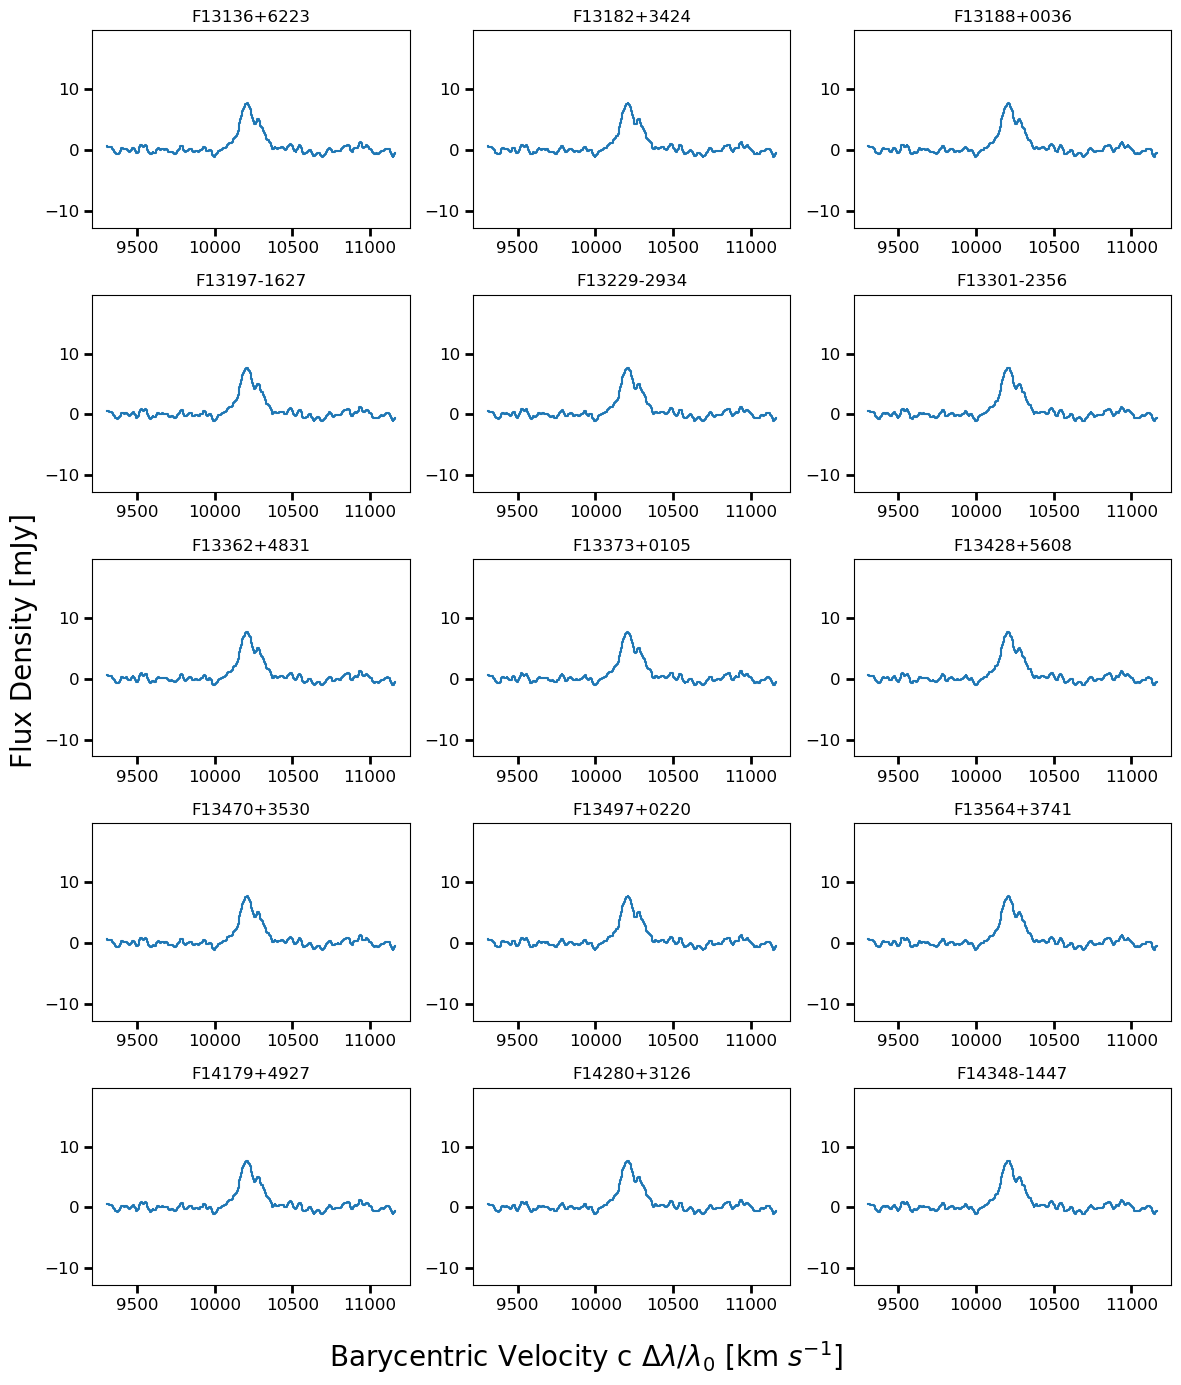

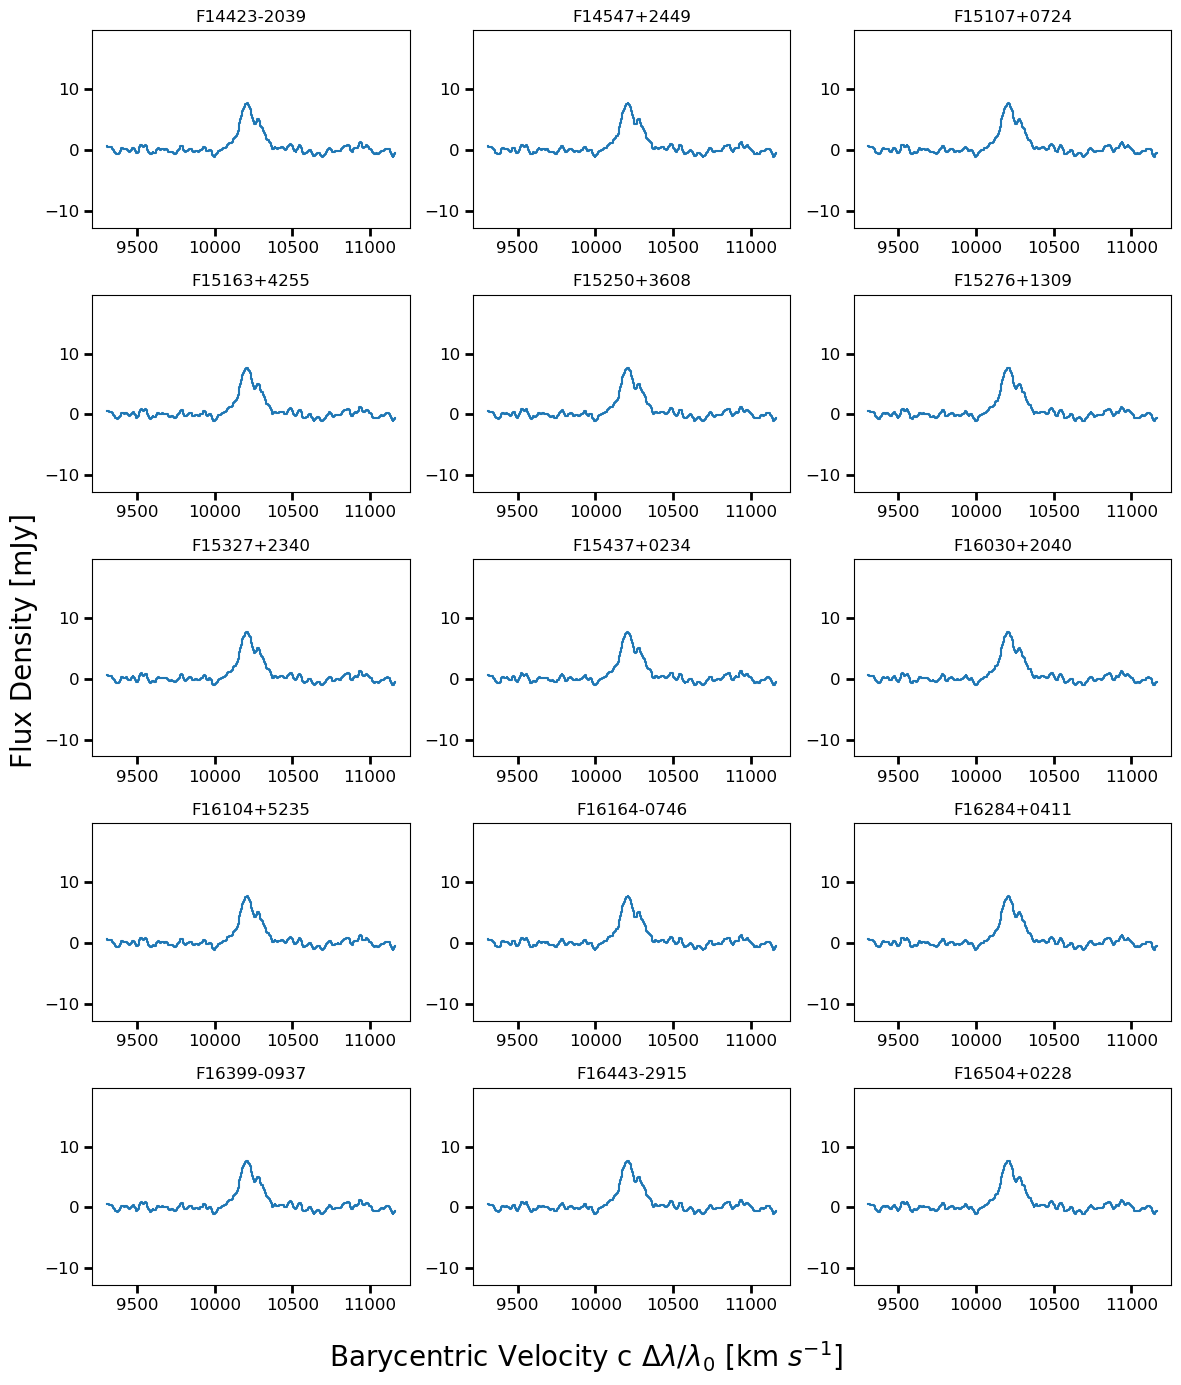

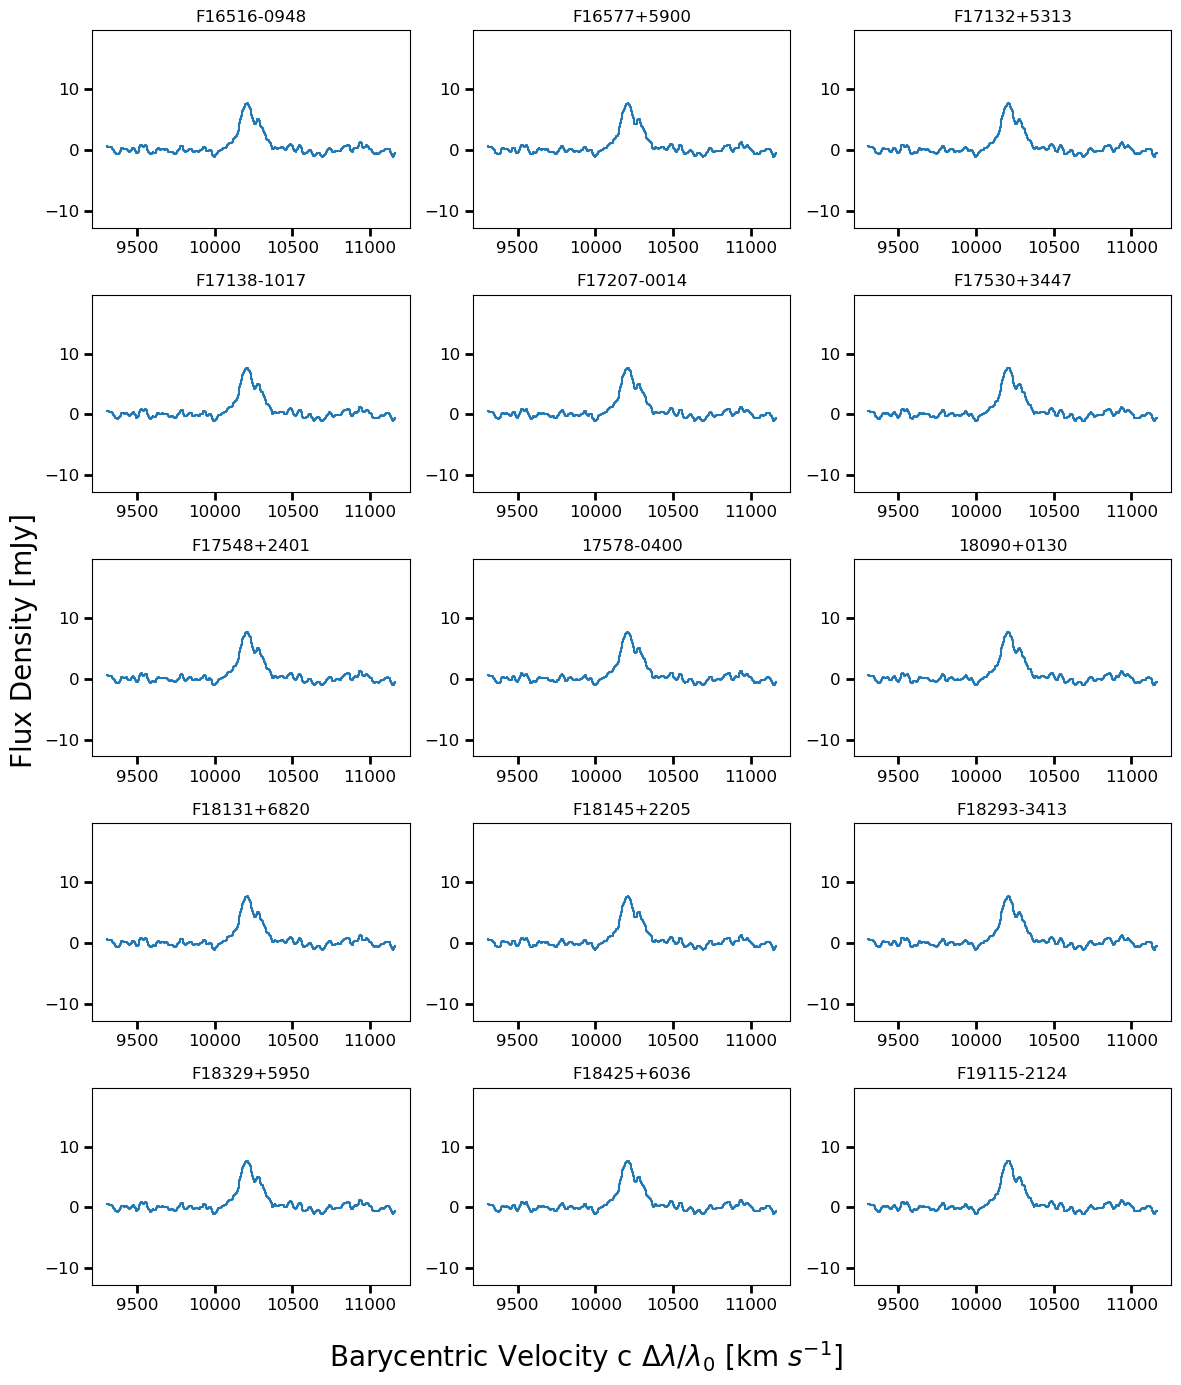

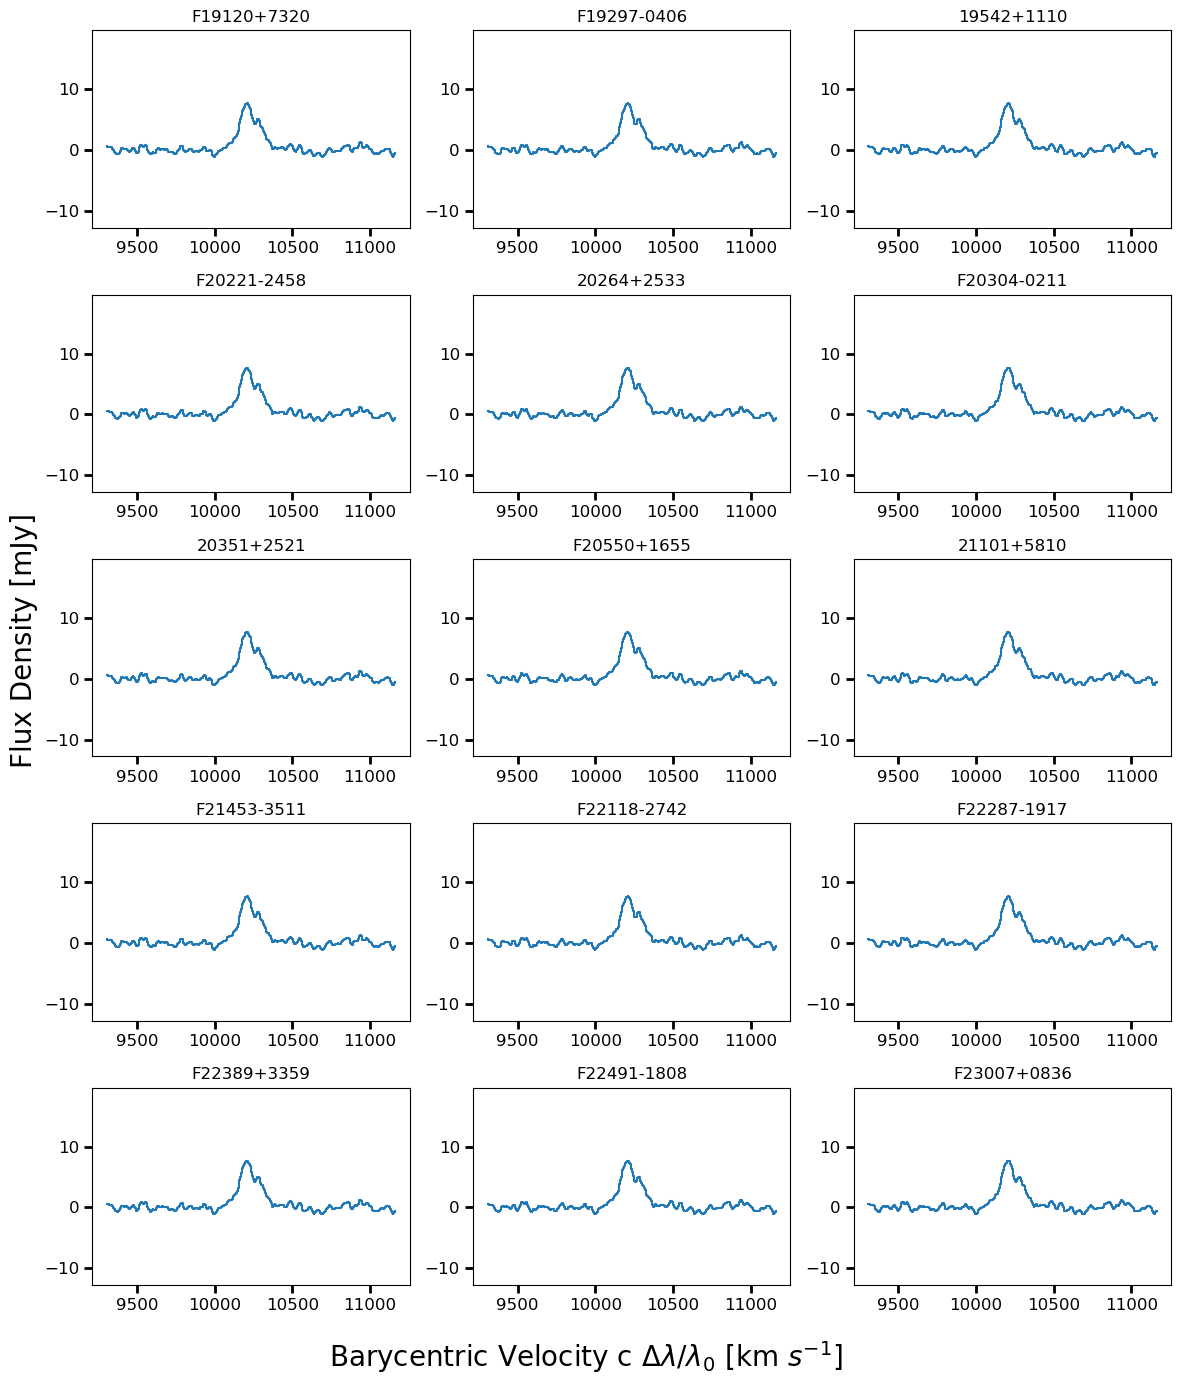

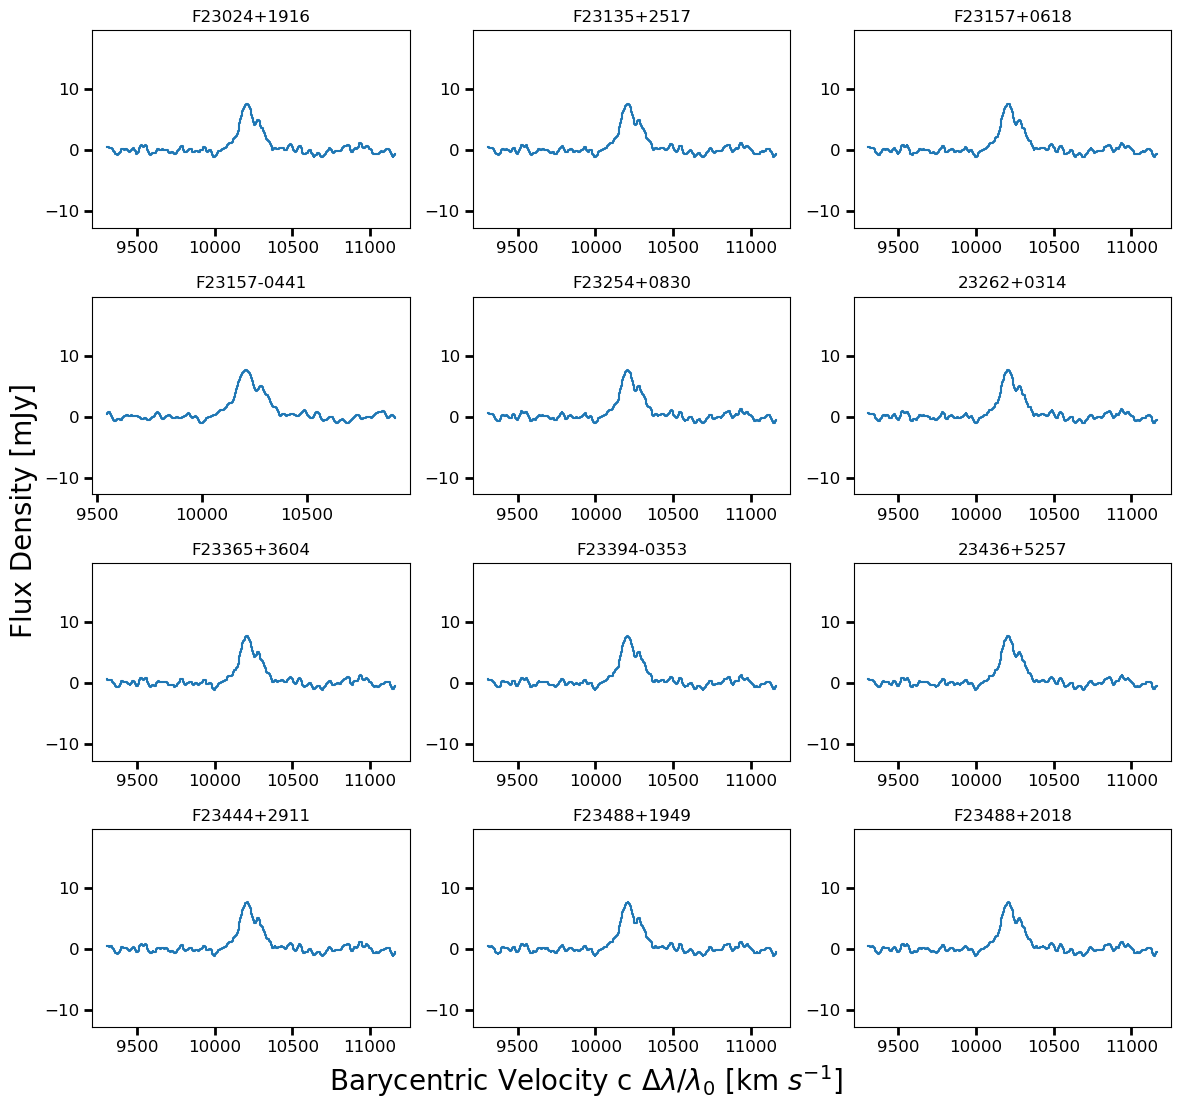

In [4]:
# Collect valid .txt files
txt_files = sorted([f for f in os.listdir(folder_path + 'DATAv3/TXT') if f.endswith('.txt')])
valid_files = []
valid_data = []
name = []
# Load and filter valid 2-column txts
for filename in txt_files:
    path = os.path.join(folder_path + 'DATAv3/TXT', filename)
    try:
        df = pd.read_csv(path, sep='\s+', skiprows=3, header=None)
        if df.shape[1] == 2:
            valid_files.append(filename)
            valid_data.append(df)
    except Exception as e:
        print(f"Skipping {filename}: {e}")

# Plot in batches of 15 (3 columns × 5 rows)
batch_size = 15
total = len(valid_files)
print(total)
num_batches = math.ceil(total / batch_size)

for b in range(num_batches):
    start = b * batch_size
    end = min(start + batch_size, total)
    batch_files = valid_files[start:end]
    batch_data = valid_data[start:end]

    n = len(batch_files)
    cols = 3
    rows = 5  # fixed 3x5 grid
    if b == num_batches - 1:
        rows = 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for i in range(n):
        for k in df1.name:
            if k in batch_files[i]:
                name = k
                break
        if 'F03164+4119' in batch_files[i] or 'F23157-0441' in batch_files[i] or 'F06107+7822' in batch_files[i]:

            begin = 150
            stop = -150
        else:
            begin = 100
            stop = -100
        ax = axes[i]
        ax.plot(batch_data[i][0][begin:stop] , gaussian_filter1d(batch_data[i][1][begin:stop],2) * 1000, drawstyle='steps-mid')
        ax.set_ylim(np.min(batch_data[i][1][begin:stop] * 1000) - 10, np.max(batch_data[i][1][begin:stop] * 1000) + 10)
        ax.set_title(k)
        ax.tick_params(axis='both', which='both', length=6, width=2, labelsize=12)
        

    # Hide unused subplots in the final (partial) batch
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    # Shared labels and title
    fig.supxlabel(r'Barycentric Velocity c $\Delta\lambda / \lambda_0$ [km $s^{-1}$]', fontsize=20)
    fig.supylabel('Flux Density [mJy]', fontsize=20)

    # Layout adjustments
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])   # Leaves space for suptitle and xlabel

    
    fig.subplots_adjust(bottom=0.07)             # Pushes xlabel closer to subplots

    plt.show()
    plt.close(fig)  # Frees memory, prevents layout bleed across figures